In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle5 as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
import random
import datetime

2023-01-18 13:16:34.751353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 13:16:35.218726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 13:16:35.218756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 13:16:37.712647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

ModuleNotFoundError: No module named 'pickle5'

In [ ]:
def convert_onehot(next_element):
    if (next_element == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'
def convert_label(next_element):
    if next_element == 2 : return 'no industry'
    elif next_element == 1 : return 'steel'
    elif next_element == 0 : return 'coal'
    else: return 'not valid'


In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
x_size = 230
y_size = 230

In [4]:

ch1_mean, ch1_std = 970.4162, 1051.8454
ch2_mean, ch2_std = 1176.249, 1031.262
ch3_mean, ch3_std = 1273.2376, 1117.068
ch4_mean, ch4_std = 2266.9050, 1241.5509
means = [ch1_mean,ch2_mean,ch3_mean,ch4_mean]
vari = [ch1_std, ch2_std, ch3_std, ch4_std]

def load_features(name):
    decoded = name
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            if (file["B02"].shape[1]<230 or file["B02"].shape[2]<230): 
                print("oh oh, downloaded patch too smol:", decoded)
            B02, B03, B04, B08 = file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]
            B02 = (B02-ch1_mean)/ch1_std
            B03 = (B03-ch2_mean)/ch2_std
            B04 = (B04-ch3_mean)/ch3_std
            B08 = (B08-ch4_mean)/ch4_std
            features = np.array([ B02, B03, B04, B08]).transpose(1,2,0)
            # features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)
        
def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.double, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

In [5]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [6]:
print(len(pkl_files))

2186


In [7]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [8]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [9]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [10]:
print(len(pkl_files_steel))


1693


In [11]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
random.Random(42).shuffle(pkl_files)
# pkl_files=pkl_files[0:100]

In [12]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [13]:
print(len(pkl_files))

7839


In [174]:
dataset_len=len(pkl_files)

train_size = int(np.floor(0.8 * dataset_len))
valid_size = int(np.floor(0.1 * dataset_len))
test_size = int(np.floor(0.1 * dataset_len))

train = tf.data.Dataset.from_tensor_slices(pkl_files[0:train_size]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)
valid = tf.data.Dataset.from_tensor_slices(pkl_files[train_size:train_size+valid_size]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)
valid = tf.data.Dataset.from_tensor_slices(pkl_files[train_size+valid_size:]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)

In [175]:
valid_files = pkl_files[train_size+valid_size:]

In [16]:
lmodel = keras.models.load_model('saved_models/resnet50v2/')

In [176]:
y = valid.map(lambda x, y: y)

In [177]:
labels = y.as_numpy_iterator()

In [178]:
labels

In [179]:
label_n = np.array([], dtype=int)
for i in labels:
    if (i == [0, 0, 1]).all():
        label_n = np.append(label_n,2)
    elif (i == [0, 1,0]).all():
        label_n = np.append(label_n,1)
    elif (i == [1, 0, 0]).all():
        label_n = np.append(label_n,0)    
    # print(label_n)

In [21]:
# label_n = label_n.reshape(-1,3)

In [22]:
# label_n = label_n[1:]

In [180]:
pred=tf.nn.softmax(lmodel.predict(valid.batch(10)))

79/79 [==============================] - 12s 145ms/step


In [24]:
np.shape(pred.numpy())

(783, 3)

In [25]:
np.shape(label_n)

(783,)

## Filter by confidently misclassified 

In [26]:
discard_list = list()

In [27]:
from cleanlab.filter import find_label_issues

ordered_label_issues = find_label_issues(
    labels=label_n,
    pred_probs=pred.numpy(),
    return_indices_ranked_by='self_confidence',
)

In [28]:
ordered_label_issues

array([1264,  928, 1810, 1358, 1474,  512,  108,  415, 1401, 2838, 1995,
       1294, 1913, 1642,  524,   27, 3031, 2305, 1598, 3673,  834, 3077,
       3044, 1631, 1819, 1729,  737, 2884, 2286, 3402, 1032,  163, 2740,
       1929, 2361, 2887,  948,  525, 3419, 2147, 1830,   92, 3540,  935,
       1671, 2032,  218,  402, 2386, 2300, 2829,  685,  530,  987, 1668,
        140,  161,  204, 2970,  381, 2355, 3535, 3565, 2751,  552, 1374,
        996, 3380, 1475, 2907, 3365,  576, 2282,  439, 3930, 3176,  908,
       3266, 2897, 2350, 1357,  309, 3126,  727, 2942, 3511, 1326, 3323,
       1930, 3172,   49, 3828, 1857,  541, 2984, 1466,  298, 2552,  330,
        132,  980, 1736, 2944, 1053,  261,  224,  323, 3970, 2158, 1685,
       3449, 3196,  971, 1341,  278, 3339, 3275, 2176, 2860, 2841,  559,
       1865, 1407,  670, 1022, 2196, 3750, 1900,  924, 2670, 2810, 3251,
       1522,  238, 3075, 1727,  191, 2068,  801, 3699,  274,  598, 2059])

In [30]:
# j = 0

In [290]:
j

91

In [421]:
index = ordered_label_issues[j]
j += 1
print(index)
print(label_n[ index])
print(np.round(pred.numpy()[index],2))

IndexError: index 143 is out of bounds for axis 0 with size 143

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


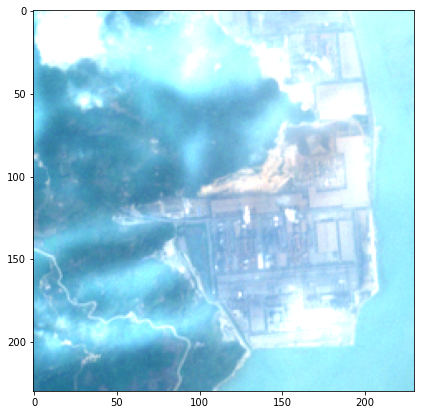

In [422]:
plt.figure(figsize=(7,7))
im = load_features(valid_files[index])[0]
plt.imshow((np.flip(im[:,:,0:3]+np.abs(im.mean())*0+0.5, axis=2)))


In [397]:
valid_files[index]

'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\\GASTDEU0005.pickle'

In [398]:
discard_list.append(valid_files[index])

In [424]:
np.save('discard2half', np.array( discard_list))

In [425]:
for file in discard_list:
    os.remove(file)

In [ ]:
# plt.figure(figsize=(7,7))
# for i in valid.skip(index).take(1).as_numpy_iterator():
#     print(i[0].shape)
#     im = i[0]
#     plt.imshow((np.flip(im[:,:,0:3]+np.abs(im.mean())*2, axis=2)))

## Filter wrong predictions for clouds

In [181]:
wrong_pred = np.where((label_n == np.argmax(pred.numpy(), axis=1)) == False)

In [182]:
len(wrong_pred[0])/len(label_n)

0.1197452229299363

In [30]:
discard_list = list()

In [183]:
j = 0

In [35]:
# label_n[index]

In [36]:
# j-=1


In [382]:
index = wrong_pred[0][j]
j += 1
print(index)
print('truth: ', convert_label(label_n[ index]))
print('pred: ',convert_label(np.argmax(pred.numpy()[index])))
print(np.round(pred.numpy()[index].max(),2))

IndexError: index 94 is out of bounds for axis 0 with size 94

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


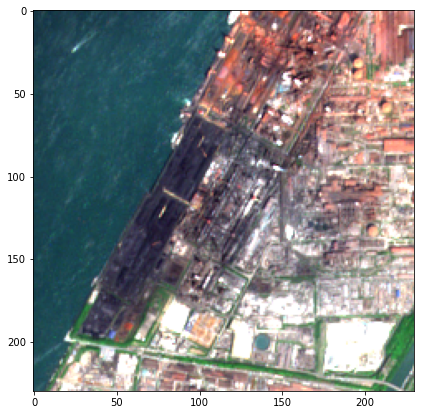

In [383]:
plt.figure(figsize=(7,7))
im = load_features(valid_files[index])[0]
plt.imshow((np.flip(im[:,:,0:3]-im[:,:,0:3].mean(axis=0).mean(axis=0)+0.5, axis=2)))


In [317]:
valid_files[index]

'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\\SDE00002.pickle'

In [373]:
discard_list.append(valid_files[index])

In [384]:
discard_list

['E:/Users/sentinel_industry/downloaded_aois/coal\\G107895.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal\\G105317.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal\\G100670.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal\\G102671.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal\\G115073.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\\SDE00002.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal\\G100611.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal\\G103681.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\\G108206.pickle',
 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\\G101409.pickle']

In [385]:
for file in discard_list:
    os.remove(file)